In [5]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import matplotlib.pyplot as plt

TRAIN = r'C:\Users\Samarth\Documents\Masters\Semester 3\Deep learning\dogs-vs-cats\train'
TEST = r'C:\Users\Samarth\Documents\Masters\Semester 3\Deep learning\dogs-vs-cats\test1'
IMG_SIZE = 125
LEARN_RATE = 1e-4

MODEL_NAME = 'DogsVsCats.Project504'


In [9]:
  def label_img(img):
    label = img.split('.')[-3]
    
    if label == 'cat':
        return [1,0] # 100% Cat, 0% Dog
    elif label == 'dog':
        return [0,1] # 0% Cat, 100% Dog

In [10]:
def create_train_data():
    train_data = []
    
    imgs = os.listdir(TRAIN)
    
    for img in tqdm(imgs):
        path = os.path.join(TRAIN, img)   
        
        label = label_img(img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        
        train_data.append([np.array(img), np.array(label)])
        
    shuffle(train_data)
    np.save('train_data.npy', train_data)

    return train_data

In [11]:
def process_test_data():
    test_data = []
    
    imgs = os.listdir(TEST)
    
    for img in tqdm(imgs):
        path = os.path.join(TEST, img)
        
        img_num = img.split('.')[0] # Example filename: cat.1.jpg (we want 'cat')
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        
        test_data.append([np.array(img), np.array(img_num)])
    
    np.save('test_data.npy', test_data)
    return test_data


In [12]:
train_data = create_train_data()

100%|██████████| 25000/25000 [02:43<00:00, 152.79it/s]


In [13]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LEARN_RATE, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [14]:
train = train_data[:-1000]
test = train_data[-1000:]

In [15]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=9, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3374  | total loss: 0.37771 | time: 603.567s
| Adam | epoch: 009 | loss: 0.37771 - acc: 0.8325 -- iter: 23936/24000
Training Step: 3375  | total loss: 0.37208 | time: 610.575s
| Adam | epoch: 009 | loss: 0.37208 - acc: 0.8336 | val_loss: 0.48655 - val_acc: 0.7890 -- iter: 24000/24000
--


In [16]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\Samarth\DogsVsCats.Project504 is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:25<00:00, 486.01it/s]


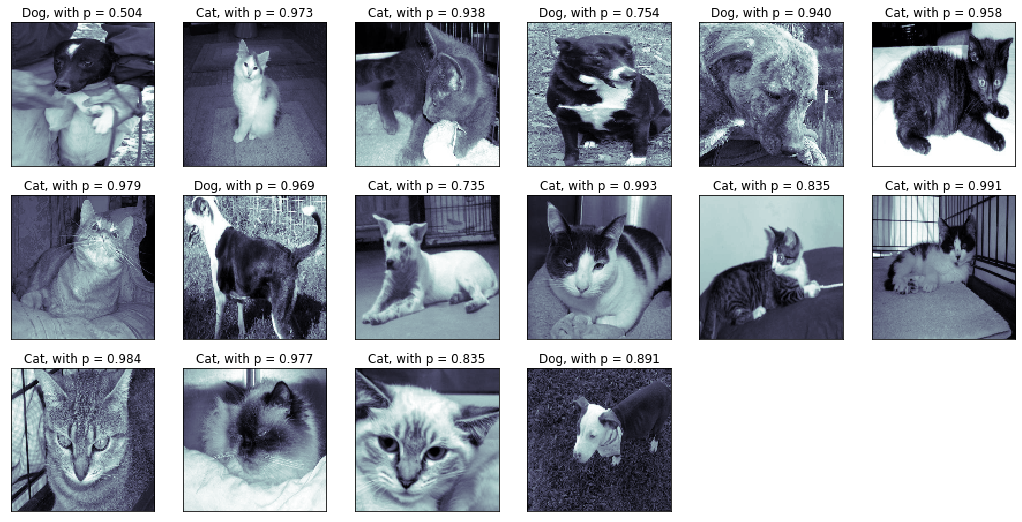

In [18]:
test_data = process_test_data()

fig = plt.figure(figsize=(18, 9))

for num, data in enumerate(test_data[:16]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,6, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    p_dog = "p = " + str(model_out[1])[:5]
    p_cat = "p = " + str(model_out[0])[:5]
    
    if model_out[0] < 0.5:
        str_label = "Dog, with " + p_dog
    else:
        str_label = "Cat, with " + p_cat
    
#     if np.argmax(model_out) == 1:
#         str_label = "Dog"
#     else:
#         str_label = "Cat"
    
    y.imshow(orig, cmap='bone')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()